# This Notebook is Model Testing for SubClass instances of Classification Codes

In [1]:
# Import all necessary packages

import ast
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt

from prettytable import PrettyTable

2023-07-27 11:26:22.786312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# All Data

The subsequent section will test the performance of the following models on the whole dataset:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks


In [3]:
# Load the data
df = pd.read_csv('Data_Preprocessed_SubClass.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N]
1,imag sens devic imag sens devic includ substra...,[H01L]
2,antigen specif immunotherapi covid19 fusion pr...,"[A61P, C07K, A61K, C12N]"
3,secur deescal data access concept technolog di...,[G06F]
4,system method secur cloudbas physiolog data pr...,"[A61B, G16Z, G16H, G06F]"


In [4]:
# As most multi-label classifiers requres each class to have multiple instances.
# All codes which appear less than 5 times will be removed

for i in range(10):

    # Determine the codes to be removed
    unique_codes = df['Classification Codes'].explode().value_counts()
    codes_to_remove = unique_codes[unique_codes < 5 ].index.tolist()

    # Remove rows with empty 'Classification Codes' column
    df = df.dropna(subset=['Classification Codes'])

    # Remove codes in the list codes_to_remove
    df['CodeCount'] = df['Classification Codes'].apply(lambda codes: sum(code in codes_to_remove for code in codes))
    df = df[df['CodeCount'] == 0].drop(columns=['CodeCount'])

In [5]:
# Now all codes will have a minimum of 5 instances
print(unique_codes)

A61B    5937
G06F    2503
H04L    2011
G16H    2003
G06T    1885
        ... 
G21F       5
F16B       5
A24F       5
F16C       5
F21W       5
Name: Classification Codes, Length: 184, dtype: int64


In [6]:
# Encode "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [7]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [10]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.20777957860615884
Hamming Loss: 0.010178986681699668


## Random Forest Classifier 


In [13]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.2119935170178282
Hamming Loss: 0.00960291734197731


## Support Vector Machine  (One vs Rest)


In [8]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.16499189627228525
Hamming Loss: 0.01193185821999859


## Deep Neural Networks 

In [9]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build basic deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10


2023-07-27 11:56:41.355522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


309/309 [==============================] - 9s 26ms/step - loss: 0.0867 - accuracy: 0.4549 - val_loss: 0.0353 - val_accuracy: 0.5065
Epoch 2/10
309/309 [==============================] - 7s 22ms/step - loss: 0.0279 - accuracy: 0.5858 - val_loss: 0.0318 - val_accuracy: 0.5446
Epoch 3/10
309/309 [==============================] - 7s 23ms/step - loss: 0.0203 - accuracy: 0.6052 - val_loss: 0.0314 - val_accuracy: 0.5579
Epoch 4/10
309/309 [==============================] - 7s 22ms/step - loss: 0.0155 - accuracy: 0.6171 - val_loss: 0.0327 - val_accuracy: 0.5588
Epoch 5/10
309/309 [==============================] - 7s 22ms/step - loss: 0.0122 - accuracy: 0.6235 - val_loss: 0.0352 - val_accuracy: 0.5239
Epoch 6/10
309/309 [==============================] - 8s 24ms/step - loss: 0.0097 - accuracy: 0.6204 - val_loss: 0.0378 - val_accuracy: 0.5280
Epoch 7/10
309/309 [==============================] - 7s 23ms/step - loss: 0.0079 - accuracy: 0.6263 - val_loss: 0.0412 - val_accuracy: 0.5166
Epoch 8/10

In [10]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.4549, Validation Accuracy: 0.5065
Epoch 2 - Accuracy: 0.5858, Validation Accuracy: 0.5446
Epoch 3 - Accuracy: 0.6052, Validation Accuracy: 0.5579
Epoch 4 - Accuracy: 0.6171, Validation Accuracy: 0.5588
Epoch 5 - Accuracy: 0.6235, Validation Accuracy: 0.5239
Epoch 6 - Accuracy: 0.6204, Validation Accuracy: 0.5280
Epoch 7 - Accuracy: 0.6263, Validation Accuracy: 0.5166
Epoch 8 - Accuracy: 0.6227, Validation Accuracy: 0.5365
Epoch 9 - Accuracy: 0.6304, Validation Accuracy: 0.5130
Epoch 10 - Accuracy: 0.6215, Validation Accuracy: 0.5097

Hamming Loss: 0.008989852723557184


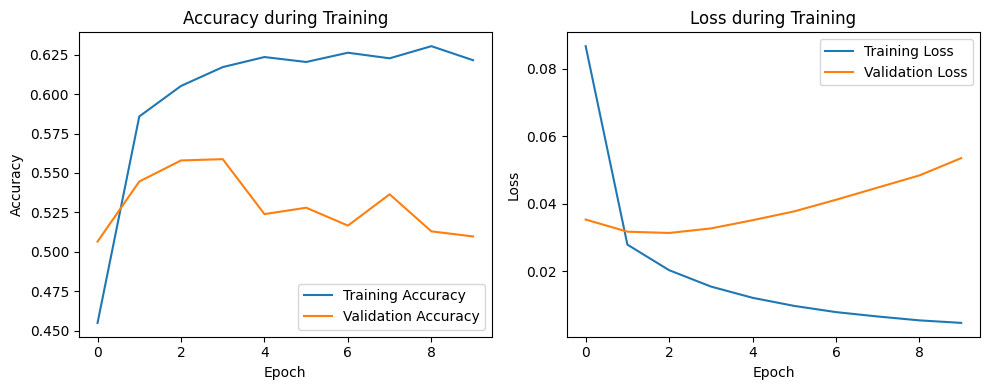

In [11]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Top 18 Codes

The subsequent section will utalise a subset of the whole data. This subset only contains the set of top 18 codes by frequency these codes are (removed repeated codes):

- A61B  
- A61K 
- G06K 
- G06N 
- G06T 
- G16H    
- H04L
- H04W 



The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [12]:
# Load the data for top 18 codes
df = pd.read_csv('Data_Preprocessed_SubClass_Top18.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N]
1,antigen specif immunotherapi covid19 fusion pr...,[A61K]
2,system method secur cloudbas physiolog data pr...,"[A61B, G16H]"
3,collim detector base medic imag system medic i...,[A61B]
4,method devic determin relat two entiti method ...,"[G06N, G06K]"


In [13]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [14]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##  Logistic Regression

In [15]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.5483993902439024
Hamming Loss: 0.09413109756097561


## Random Forest 

In [16]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.5678353658536586
Hamming Loss: 0.08665205792682927


## Support Vector Machine  (One vs Rest)


In [17]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.5034298780487805
Hamming Loss: 0.10613567073170732


## Deep Neural Networks 

In [18]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
263/263 [==============================] - 7s 26ms/step - loss: 0.2319 - accuracy: 0.7019 - val_loss: 0.1925 - val_accuracy: 0.6824
Epoch 2/10
263/263 [==============================] - 8s 29ms/step - loss: 0.1168 - accuracy: 0.7701 - val_loss: 0.2056 - val_accuracy: 0.6957
Epoch 3/10
263/263 [==============================] - 8s 30ms/step - loss: 0.0672 - accuracy: 0.8071 - val_loss: 0.2355 - val_accuracy: 0.6933
Epoch 4/10
263/263 [==============================] - 9s 35ms/step - loss: 0.0389 - accuracy: 0.8112 - val_loss: 0.2799 - val_accuracy: 0.7033
Epoch 5/10
263/263 [==============================] - 6s 25ms/step - loss: 0.0218 - accuracy: 0.8231 - val_loss: 0.3210 - val_accuracy: 0.6990
Epoch 6/10
263/263 [==============================] - 7s 25ms/step - loss: 0.0141 - accuracy: 0.8241 - val_loss: 0.3709 - val_accuracy: 0.6862
Epoch 7/10
263/263 [==============================] - 6s 24ms/step - loss: 0.0090 - accuracy: 0.8288 - val_loss: 0.4042 - val_accuracy: 0.7019

In [19]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.7019, Validation Accuracy: 0.6824
Epoch 2 - Accuracy: 0.7701, Validation Accuracy: 0.6957
Epoch 3 - Accuracy: 0.8071, Validation Accuracy: 0.6933
Epoch 4 - Accuracy: 0.8112, Validation Accuracy: 0.7033
Epoch 5 - Accuracy: 0.8231, Validation Accuracy: 0.6990
Epoch 6 - Accuracy: 0.8241, Validation Accuracy: 0.6862
Epoch 7 - Accuracy: 0.8288, Validation Accuracy: 0.7019
Epoch 8 - Accuracy: 0.8253, Validation Accuracy: 0.6986
Epoch 9 - Accuracy: 0.8378, Validation Accuracy: 0.6995
Epoch 10 - Accuracy: 0.8304, Validation Accuracy: 0.7052

Hamming Loss: 0.07760099085365854


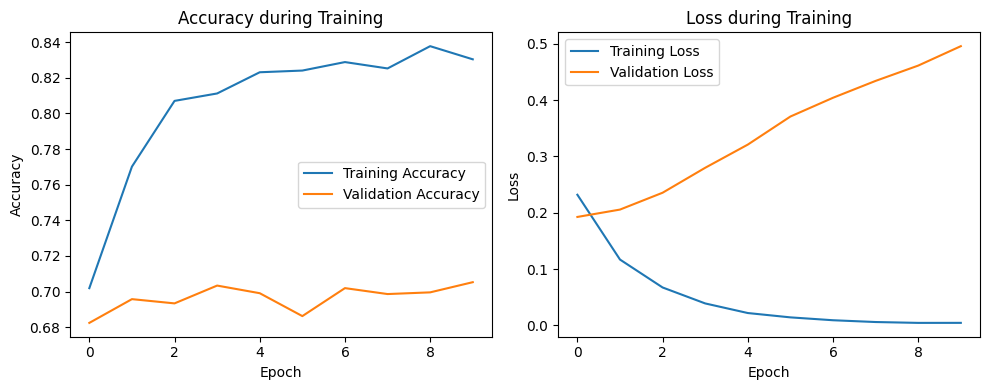

In [20]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Selected 7 Codes

The subsequent section will utalise a smaller subset of the whole data. This subset only contains the set of selected 7 codes by Beyond Blood, these codes are (removed repeated codes):

- A61B    
- G06K 
- G06N 
- G16H


The following models will be tested to get the accuracy and hamming loss:

- Logistic Regression
- Random Forest Classifier
- Support Vector Machine
- Deep Nerual Networks

In [21]:
# Load the data for selected 7 codes by Beyond Blood
df = pd.read_csv('Data_Preprocessed_SubClass_Selected7.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N]
1,system method secur cloudbas physiolog data pr...,"[A61B, G16H]"
2,collim detector base medic imag system medic i...,[A61B]
3,method devic determin relat two entiti method ...,"[G06N, G06K]"
4,system method teach composition convolut neura...,"[G06K, G06N]"


In [22]:
# Encode the "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [23]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## Logistic Regression 

In [24]:
logistic_regression = LogisticRegression()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(logistic_regression)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.5994301994301995
Hamming Loss: 0.14572649572649574


## Random Forest 

In [25]:
classifier = RandomForestClassifier()

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.6330484330484331
Hamming Loss: 0.13319088319088318


## Support Vector Machine  (One vs Rest)


In [26]:
svm_classifier = SVC(kernel='linear')

# Use MultiOutputClassifier for multi-label classification
multi_label_classifier = MultiOutputClassifier(svm_classifier)

# Train the model
multi_label_classifier.fit(X_train_vectorized, y_train)

# Make predictions
y_pred = multi_label_classifier.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)

Accuracy: 0.5663817663817664
Hamming Loss: 0.1613960113960114


## Deep Neural Networks

In [27]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Use sigmoid activation for multi-label classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

Epoch 1/10
176/176 [==============================] - 2s 12ms/step - loss: 0.3188 - accuracy: 0.7739 - val_loss: 0.2861 - val_accuracy: 0.8013
Epoch 2/10
176/176 [==============================] - 2s 12ms/step - loss: 0.1612 - accuracy: 0.8551 - val_loss: 0.3173 - val_accuracy: 0.8041
Epoch 3/10
176/176 [==============================] - 2s 12ms/step - loss: 0.0849 - accuracy: 0.8833 - val_loss: 0.3656 - val_accuracy: 0.7927
Epoch 4/10
176/176 [==============================] - 2s 10ms/step - loss: 0.0420 - accuracy: 0.8861 - val_loss: 0.4780 - val_accuracy: 0.7977
Epoch 5/10
176/176 [==============================] - 2s 10ms/step - loss: 0.0191 - accuracy: 0.8890 - val_loss: 0.5500 - val_accuracy: 0.8027
Epoch 6/10
176/176 [==============================] - 2s 13ms/step - loss: 0.0118 - accuracy: 0.8901 - val_loss: 0.6023 - val_accuracy: 0.7942
Epoch 7/10
176/176 [==============================] - 2s 11ms/step - loss: 0.0053 - accuracy: 0.8913 - val_loss: 0.6650 - val_accuracy: 0.8063

In [28]:
# Get accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy and validation accuracy for each epoch
for epoch in range(len(accuracy)):
    print(f"Epoch {epoch + 1} - Accuracy: {accuracy[epoch]:.4f}, Validation Accuracy: {val_accuracy[epoch]:.4f}")
    
# Print hamming loss
print("\nHamming Loss:", hamming_loss_value)

Epoch 1 - Accuracy: 0.7739, Validation Accuracy: 0.8013
Epoch 2 - Accuracy: 0.8551, Validation Accuracy: 0.8041
Epoch 3 - Accuracy: 0.8833, Validation Accuracy: 0.7927
Epoch 4 - Accuracy: 0.8861, Validation Accuracy: 0.7977
Epoch 5 - Accuracy: 0.8890, Validation Accuracy: 0.8027
Epoch 6 - Accuracy: 0.8901, Validation Accuracy: 0.7942
Epoch 7 - Accuracy: 0.8913, Validation Accuracy: 0.8063
Epoch 8 - Accuracy: 0.8872, Validation Accuracy: 0.8041
Epoch 9 - Accuracy: 0.8918, Validation Accuracy: 0.8020
Epoch 10 - Accuracy: 0.8920, Validation Accuracy: 0.8013

Hamming Loss: 0.11866096866096866


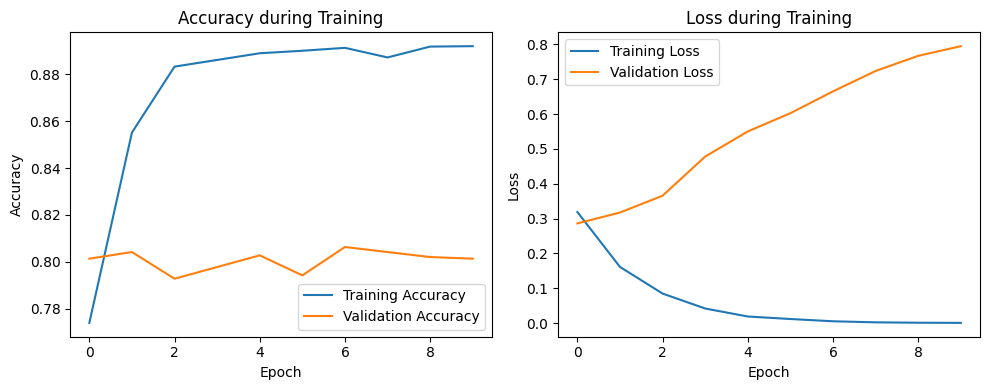

In [29]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Results
This section presents all results from the model into a table format for ease of visualisation

In [30]:
def results_table(data):
    table = PrettyTable()
    
    # Define column headers
    table.field_names = ["Model", "Accuracy", "Hamming Loss"]
    
    # Add data
    for row in data:
        table.add_row(row)
        
    # Align data
    table.align["Model"] = "l"
    table.align["Accuracy"] = "r"
    table.align["Hamming Loss"] = "r"
    table.float_format = ".4"

    print(table)

In [31]:
# Data for the table
data_all = [
    ["Logistic Regression", 0.2078, 0.0102],
    ["Random Forest", 0.2120, 0.0096],
    ["Support Vector Machine", 0.1650, 0.0119],
    ["Deep Neural Networks", 0.5588, 0.0090]
]

data_top18 = [
    ["Logistic Regression", 0.3091, 0.0741],
    ["Random Forest", 0.2635, 0.0732],
    ["Support Vector Machine", 0.2758, 0.0839],
    ["Deep Neural Networks", 0.6090, 0.0645]
]

data_selected7 = [
    ["Logistic Regression", 0.5994, 0.1457],
    ["Random Forest", 0.6330, 0.1332],
    ["Support Vector Machine", 0.5664, 0.1614],
    ["Deep Neural Networks", 0.8063, 0.1187]
]

print("\t\t       \033[1mAll Data\033[0m")
results_table(data_all)

print("\n\n\t\t        \033[1mTop 18\033[0m")
results_table(data_top18)

print("\n\n\t\t       \033[1mSelected 7\033[0m")
results_table(data_selected7)

		       All Data
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.2078 |       0.0102 |
| Random Forest          |   0.2120 |       0.0096 |
| Support Vector Machine |   0.1650 |       0.0119 |
| Deep Neural Networks   |   0.5588 |       0.0090 |
+------------------------+----------+--------------+


		        Top 18
+------------------------+----------+--------------+
| Model                  | Accuracy | Hamming Loss |
+------------------------+----------+--------------+
| Logistic Regression    |   0.3091 |       0.0741 |
| Random Forest          |   0.2635 |       0.0732 |
| Support Vector Machine |   0.2758 |       0.0839 |
| Deep Neural Networks   |   0.6090 |       0.0645 |
+------------------------+----------+--------------+


		       Selected 7
+------------------------+----------+--------------+
| Model                  | Accuracy | Ha